In [1]:
import numpy as np
import scipy as scp
from numpy.random import multivariate_normal
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score as nmi_score
N_SAMPLES = 200

In [2]:
#Create simulated data
def get_synth_data1():
    c1_means = [1, 1]
    c2_means = [3, 4]
    c1_cov = [[1, 0.5],[0.5, 1.5]]
    c2_cov = [[0.3, 0.2],[0.2, 0.6]]
    means = [c1_means, c2_means]
    cov = [c1_cov, c2_cov]
    
    v_data = list()
    for co in range(2):
        samples = multivariate_normal(means[co], cov[co], N_SAMPLES)
        v_data.append(samples)
            
    v_data = np.vstack(v_data)
    
    labels = np.concatenate((np.zeros((N_SAMPLES,)), np.ones((N_SAMPLES,))))
    
    shuffle_inds = np.random.permutation(N_SAMPLES * 2)
    v_data = v_data[shuffle_inds]
    labels = labels[shuffle_inds]
    
    return v_data, labels

In [3]:
def get_synth_data():
    c1_means = [[1, 1],[1, 2],[1, 1]]
    c2_means = [[3, 4],[2, 2],[3, 3]]
    c1_cov = list()
    c1_cov.append([[1, 0.5],[0.5, 1.5]])
    c1_cov.append([[1, -0.2],[-0.2, 1]])
    c1_cov.append([[1.2, 0.2],[0.2, 1]])
    c2_cov = list()
    c2_cov.append([[0.3, 0.2],[0.2, 0.6]])
    c2_cov.append([[0.6, 0.1],[0.1, 0.5]])
    c2_cov.append([[1, 0.4],[0.4, 0.7]])
    means = [c1_means, c2_means]
    cov = [c1_cov, c2_cov]
    v_data =  [[],[],[]]
    
    for co in range(2):
        for vi in range(3):
            samples = multivariate_normal(means[co][vi], cov[co][vi], N_SAMPLES)
            v_data[vi].append(samples)
            
    for vi in range(3):
        v_data[vi] = np.vstack(v_data[vi])
    
    labels = np.concatenate((np.zeros((N_SAMPLES,)), np.ones((N_SAMPLES,))))
    
    shuffle_inds = np.random.permutation(N_SAMPLES * 2)
    for vi in range(3):
        v_data[vi] = v_data[vi][shuffle_inds]
    labels = labels[shuffle_inds]
    
    return v_data, labels

In [4]:
v_data, labels = get_synth_data()

In [5]:
datafile1 = './Data/view1.csv'
datafile2 = './Data/view2.csv'
datafile3 = './Data/view3.csv'
labelfile = './Data/labels.csv'

v1_data = np.loadtxt(datafile1, delimiter = ',')
v2_data = np.loadtxt(datafile2, delimiter = ',')
v3_data = np.loadtxt(datafile3, delimiter = ',')
labels = np.loadtxt(labelfile, delimiter = ',')
v_data = [v1_data, v2_data, v3_data]

print(v1_data.shape)
print(v2_data.shape)

(1000, 2)
(1000, 2)


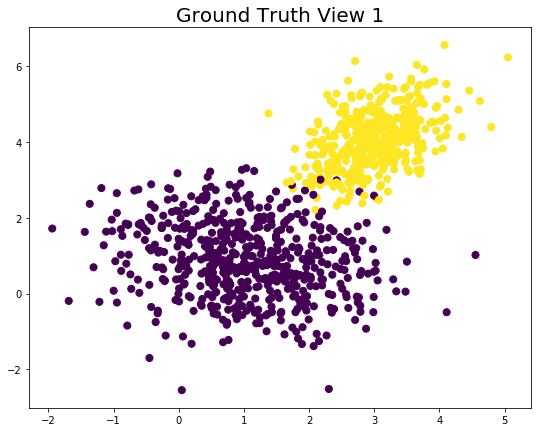

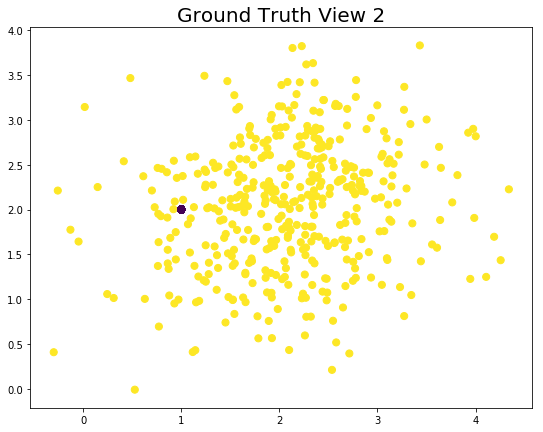

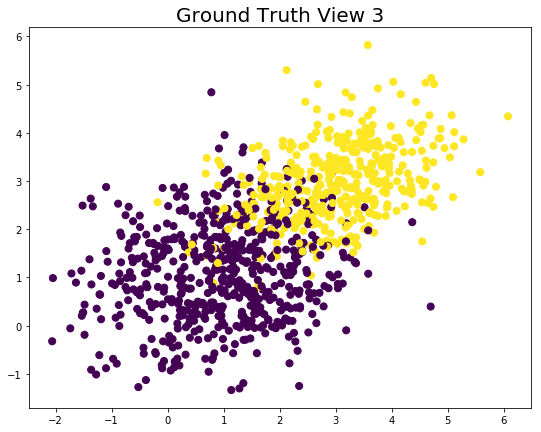

In [6]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=labels,s=dot_size, cmap=cmap)

fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 2', size=20)
ax.scatter(v_data[1][:, 0], v_data[1][:, 1],c=labels,s=dot_size, cmap=cmap)

fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 3', size=20)
ax.scatter(v_data[2][:, 0], v_data[2][:, 1],c=labels,s=dot_size, cmap=cmap)

In [7]:
def gaussian_sim(X_mat):
    
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    sq_dists = np.square(distances)
    norm_dists = sq_dists / (2 * np.median(sq_dists))
    print(np.sqrt(np.median(sq_dists)))
    sims = np.exp(-norm_dists)
    return sims

def sym(S_mat):
    mat =  (S_mat + np.transpose(S_mat))/2
    return mat + np.min(mat)

def comp_laplacian(X_mat):
    D_mat = np.diag(np.sum(X_mat, axis=1))
    D_alt = np.sqrt(np.linalg.inv(np.abs(D_mat))) 
    laplacian = D_alt @ X_mat @ D_alt
    laplacian = sym(laplacian)
    print(np.sum(laplacian))
    return laplacian

def comp_eigs(X_mat, k):
    #laplacian = scp.sparse.csgraph.laplacian(X_mat, normed=True)
    laplacian = comp_laplacian(X_mat)
    e_vals, e_vecs = np.linalg.eig(laplacian)
    indices = np.argsort(e_vals)[-k:]
    e_vecs = e_vecs[:, indices]
    
    return e_vecs

In [8]:
def single_spectral(data, k=2):
    #Compute the similarities matrices
    similarities = gaussian_sim(data)
    #Initialize matrices of eigenvectors
    U_mats = comp_eigs(similarities, k)
    #Row normalize 
    U_norm = np.linalg.norm(U_mats, axis = 1).reshape((-1, 1))
    U_norm[U_norm == 0] = 1
    V_mats = U_mats/ U_norm 
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(V_mats)
    return clusters

In [9]:
v1_clusters = single_spectral(v_data[0])
v2_clusters = single_spectral(v_data[1])

2.5656560858040756
996.7070050263221


C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


0.8887396195326321
973.6684741431244


In [10]:
nmi1 = nmi_score(v1_clusters, labels)
print(nmi1)

nmi2 = nmi_score(v2_clusters, labels)
print(nmi2)

0.890855294175599
0.5498757773332688
